## Parte 1 - Tratando os Dados de Chuva do INMET

In [2]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

### Agrupando e Identificando dados de chuva e localização
Aqui, abriremos os dados baixados no site do inmet referentes aos anos de 2013 a 2022, inclusos. Cada arquivo contém, além dos dados de chuva, a localização da estação em latitude e longitude. 
As saídas do código abaixo serão
- Ind_Pluv.dataframe, que condensará o índice pluviométrico por estação (coluna) para os dez anos (linha)
- Loc.geodataframe, que conterá a localização das estações para que possamos, no futuro, correlacionar dado de chuva com posição e interpolar dados faltantes

In [3]:
Arq2 = os.listdir('./Data_2013_2022/')
Ind_Pluv = pd.DataFrame()

code = [] ; lat = [] ; long = []; cidade = []; uf = []; altitude = []
for folder in Arq2:
    try:
        Arq = os.listdir('./Data_2013_2022/'+folder)
        Aux = pd.DataFrame()
        
        code2 = []
        for file in Arq:
            _ = pd.read_csv('./Data_2013_2022/'+folder+'/'+file,sep=';',encoding="ISO-8859-1",nrows=6)
            cidade.append(_.iloc[1,1])
            uf.append(_.iloc[0,1])
            code.append(_.iloc[2,1])
            lat.append(_.iloc[3,1])
            long.append(_.iloc[4,1])
            altitude.append(_.iloc[5,1])

            code2.append(_.iloc[2,1])
        
        for i,file in enumerate(Arq):
            _ = pd.read_csv('./Data_2013_2022/'+folder+'/'+file,sep=';',encoding="ISO-8859-1",skiprows=8,decimal=',')
            Aux[code2[i]] = _['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)'] 

  
        Ind_Pluv = pd.concat([Ind_Pluv,Aux])
    
    except:
        None

Loc = pd.DataFrame()
Loc['Cidade'] = cidade
Loc['UF'] = uf
Loc['Código'] = code
Loc['Latitude'] = lat
Loc['Longitude'] = long
Loc['Altitude'] = altitude

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6040/245326985.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Aux[code2[i]] = _['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6040/245326985.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  Aux[code2[i]] = _['PRECIPITAÇÃO TOTAL, HORÁRIO (mm)']
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6040/245326985.py:24: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling 

In [13]:
Loc.head(3)

,Cidade,UF,Código,Latitude,Longitude,Altitude,geometry,Dis_1,Viz_1,Dis_2,...,Dis_6,Viz_6,Dis_7,Viz_7,Dis_8,Viz_8,Dis_9,Viz_9,Dis_10,Viz_10
0,ARCO VERDE,PE,A309,-8.41694443,-37.08333333,680.7,POINT (-37.08333 -8.41694),0.526525,A872,0.634831,...,1.227498,A215,1.296974,A529,1.350536,A535,1.385784,A803,1.397255,A126
1,VENTANIA,PR,A872,-24.23833333,-50.24555555,1106,POINT (-50.24556 -24.23833),0.469796,A872,0.603455,...,1.336734,A215,1.384332,A529,1.535799,A535,1.544749,A803,1.573024,A126
2,RONDON DO PARA,PA,A214,-4.82749999,-48.17333332,203,POINT (-48.17333 -4.82750),0.818438,A872,0.818822,...,1.223016,A215,1.252775,A529,1.796616,A535,1.806784,A803,1.866186,A126


In [14]:
#Trocando ',' por '.'
Loc = Loc.stack().str.replace(',','.').unstack() 

#Removendo dados Duplicados, por termos lido dados de
Loc = Loc.drop_duplicates(subset=['Código']) 
Ind_Pluv = (Ind_Pluv.T.drop_duplicates()).T

#Tornando Loc um geodf
Loc = gpd.GeoDataFrame( Loc, geometry=gpd.points_from_xy(Loc.Longitude, Loc.Latitude), crs="EPSG:4326" )

#Removendo Estações do Arquipélago de São Pedro e Paulo e da Antártida de Ind_Pluv e Loc
##print(Loc.loc[ (Loc.Cidade == 'CRIOSFERA') | (Loc.Cidade =='ARQ.SAO PEDRO E SAO PAULO')  ]) #mostrando tais estações

rem_lst = Loc.loc[ (Loc.Cidade == 'CRIOSFERA') | (Loc.Cidade =='ARQ.SAO PEDRO E SAO PAULO')  ]['Código'].values
for codigo in rem_lst:
    del Ind_Pluv[codigo]

Loc = Loc.loc[ (Loc.Cidade != 'CRIOSFERA') & (Loc.Cidade != 'ARQ.SAO PEDRO E SAO PAULO')  ]

Loc.head(3)

,Cidade,UF,Código,Latitude,Longitude,Altitude,geometry,Dis_1,Viz_1,Dis_2,...,Dis_6,Viz_6,Dis_7,Viz_7,Dis_8,Viz_8,Dis_9,Viz_9,Dis_10,Viz_10
0,ARCO VERDE,PE,A309,-8.41694443,-37.08333333,680.7,POINT (-37.08333 -8.41694),NaN,A872,NaN,...,NaN,A215,NaN,A529,NaN,A535,NaN,A803,NaN,A126
1,VENTANIA,PR,A872,-24.23833333,-50.24555555,1106,POINT (-50.24556 -24.23833),NaN,A872,NaN,...,NaN,A215,NaN,A529,NaN,A535,NaN,A803,NaN,A126
2,RONDON DO PARA,PA,A214,-4.82749999,-48.17333332,203,POINT (-48.17333 -4.82750),NaN,A872,NaN,...,NaN,A215,NaN,A529,NaN,A535,NaN,A803,NaN,A126


#### Abrindo Mapa de Estados do Brasil e Plotando Localização Das Estações

In [5]:
UF = gpd.read_file('./2022/BR_UF_2022/BR_UF_2022.shp')

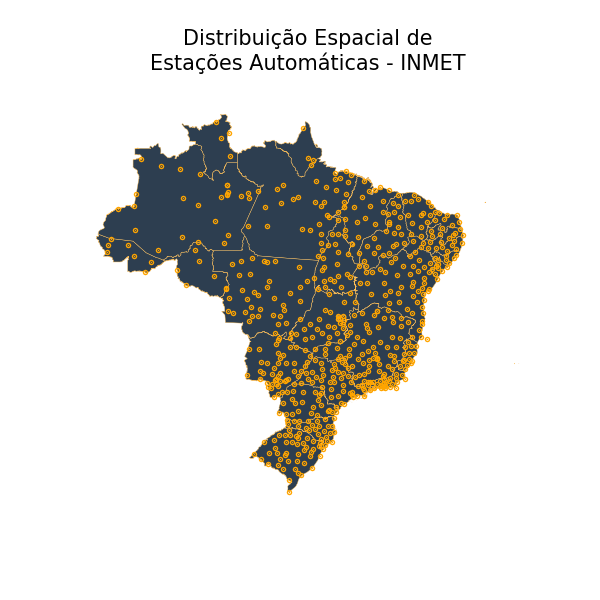

In [18]:
%matplotlib widget
fig, ax = plt.subplots(figsize=(2, 2), dpi=300)

UF.plot(facecolor="#2D3E50", edgecolor="#FEBF57", ax=ax,lw=0.1)
Loc.plot(ax=ax, color='orange',markersize=0.1)

ax.set_title("Distribuição Espacial de\nEstações Automáticas - INMET", fontsize=5)
ax.axis("off")
plt.savefig('Esp_Dist.png',dpi=300)

### Limpando a Tabela de Chuvas - Ind_Pluv
A tabela de chuvas contém muitos valores negativos e NaNs que seram substituidos através de uma interpolação ponderada pelo inverso da dsitância. Para isso, vamos identificar as dez estaçõs vizinhas de cada estação e registrá-los em Loc.geodf

In [7]:
Ind_Pluv.head(3)

,A309,A872,A214,A204,A112,A035,A215,A529,A535,A803,...,A254,A629,S706,A895,A377,S707,S716,A368,A256,A560
0,0.0,0.0,0.0,-9999.0,0.0,0.0,0.0,0.0,0.0,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,0.0,-9999.0,0.0,0.0,0.0,0.0,0.0,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,0.0,-9999.0,3.4,0.0,0.0,0.0,0.0,34.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Removendo valores negativos. Assumo-os como NaN para futura interpolação dos NaNs  
Ind_Pluv[Ind_Pluv < 0 ] = np.NAN

#Identificando os 10 vizinhos mais proximos
for i in np.arange( len(Loc) ):
    idx   = Loc.index[i]
    point = Loc.loc[ idx, 'geometry'  ]

    d = Loc.distance(point).values
    seq = np.argsort(d)
    
    for k in np.arange(10):
        Loc.loc[idx, f'Dis_{k+1}'] = d[seq[k+1]]
        Loc.loc[idx, f'Viz_{k+1}'] = Loc['Código'][Loc.index[k+1]]

Loc.sample(frac=1).head(3)

/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6040/3958263967.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  d = Loc.distance(point).values
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6040/3958263967.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'A872' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Loc.loc[idx, f'Viz_{k+1}'] = Loc['Código'][Loc.index[k+1]]
/var/folders/nd/sdq3r0ys5rx5y9pxp7c12jz40000gn/T/ipykernel_6040/3958263967.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'A214' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  Loc.loc[idx, f'Viz_{k+1}'] = Loc['Código'][Loc.i

,Cidade,UF,Código,Latitude,Longitude,Altitude,geometry,Dis_1,Viz_1,Dis_2,...,Dis_6,Viz_6,Dis_7,Viz_7,Dis_8,Viz_8,Dis_9,Viz_9,Dis_10,Viz_10
45,COSTA RICA,MS,A760,-18.82277777,-53.26722221,730,POINT (-53.26722 -18.82278),0.664762,A872,1.007426,...,1.484948,A215,1.501087,A529,1.505229,A535,1.521604,A803,1.572730,A126
2079,SELVIRIA,MS,S717,-20.351444,-51.430222,374,POINT (-51.43022 -20.35144),0.521398,A872,0.701764,...,1.142115,A215,1.262837,A529,1.448323,A535,1.465298,A803,1.606076,A126
88,CURITIBANOS,SC,A860,-27.2886111,-50.60416666,860,POINT (-50.60417 -27.28861),0.576922,A872,0.579610,...,0.966247,A215,0.978671,A529,1.164052,A535,1.192723,A803,1.256284,A126


### Substintuindo NaNs de Ind_Pluv via interpolação
##### dos 10 vizinhos mais proximos, ponderado pelo inverso da distancia ao quadrado

In [15]:
for m,j in enumerate( Ind_Pluv.columns ):
    #print(Loc.loc[ Loc['Código'] == j  ][f'Viz_{1}'])

    v = []
    d = []
    for k in np.arange(10):
        v.append( Loc.loc[ Loc['Código'] == j  ][f'Viz_{k+1}'].values[0] )
        d.append( Loc.loc[ Loc['Código'] == j  ][f'Dis_{k+1}'].values[0] )

    d = np.array(d)
    a = ( (Ind_Pluv[v]/(d**2)) /( (1/d**2).sum() ) ).sum(axis=1)

    Ind_Pluv[j] = Ind_Pluv[j].fillna( a )
#Esse procedimento deverá eliminar qualquer NaN contido no dataframe Ind_Pluv. 

## Salvando Ind_Pluv, Loc

In [17]:
Ind_Pluv.to_csv('Indice_Pluviometrico_x_Tempo.csv', sep=',',index=False)
Loc.to_csv('Infos_x_Localizacao.csv', sep=',')